# CC3084 – Data Science — **Laboratorio 5: RNN (LSTM) para Series de Tiempo**

**Serie:** *Industrial Production: Ice cream and frozen dessert (IPN31152N)*  
**Fuente:** FRED (Federal Reserve Bank of St. Louis) — https://fred.stlouisfed.org/series/IPN31152N

**Integrantes**
- Sofia Velasquez, 22049
- Jose Marchena, 22398

<a hhref="https://github.com/Sofiamishel2003/RNN_para_Series_de_Tiempo">**Repositorio**</a>

## 0) Preparación del entorno


In [1]:
%pip install -q pandas numpy matplotlib pandas_datareader

Note: you may need to restart the kernel to use updated packages.


## 1) Carga y exploración de datos

La serie **IPN31152N** está en FRED. Intentaremos descargarla con `pandas_datareader`.  


            produccion
DATE                  
2000-01-01     93.6497
2000-02-01    111.6591
2000-03-01    125.4885
2000-04-01    136.9998
2000-05-01    136.0725
       produccion
count  306.000000
mean   118.699614
std     24.802970
min     68.060900
25%    102.267825
50%    116.391150
75%    132.100425
max    196.817400


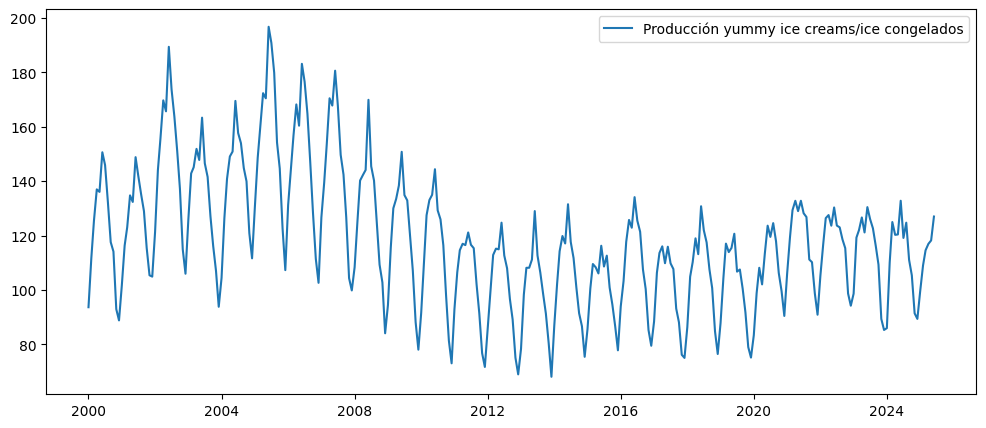

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# Descargar datos de FRED
series = web.DataReader("IPN31152N", "fred", start, end)

series.rename(columns={"IPN31152N": "produccion"}, inplace=True) # Renombrar columna

# Visualizar primeros datos
print(series.head())
print(series.describe())
plt.figure(figsize=(12,5))
plt.plot(series, label="Producción yummy ice creams/ice congelados")
plt.legend()
plt.show()

## 2) División de conjuntos

Usaremos los **últimos 24 meses** como conjunto de prueba. El resto será entrenamiento.


Entrenamiento: (282, 1)
Prueba: (24, 1)


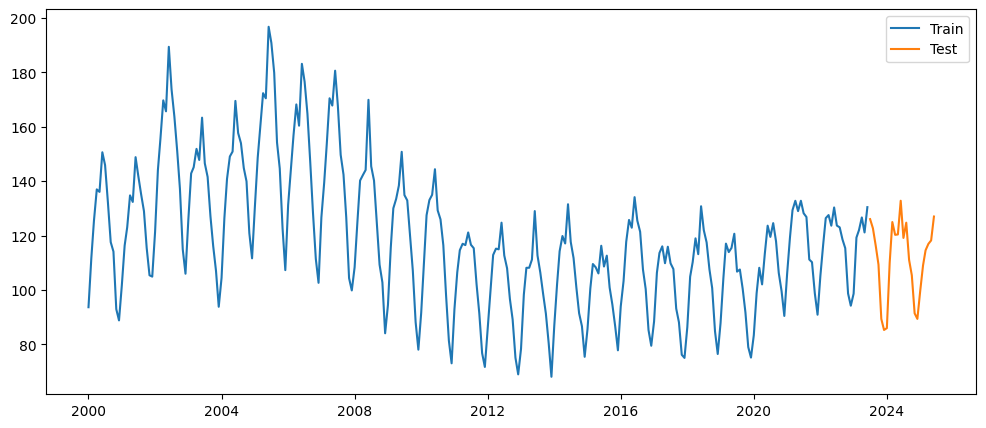

In [3]:
# Definir tamaño de prueba (24 meses)
train = series.iloc[:-24]
test = series.iloc[-24:]

print("Entrenamiento:", train.shape)
print("Prueba:", test.shape)

plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.legend()
plt.show()

## 3) Normalización y preparación

Aplicamos `MinMaxScaler` . Luego construimos un `TimeSeriesGenerator`.
- `batch_size` tamaño del lote de entrenamiento.


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
datos_entreno_escalados = scaler.transform(train)
datos_prueba_escalados = scaler.transform(test)

La longitud se basa en que estos datos son anuales por lo que se debe escoger un número de meses igual o aproximado a el número de meses en el año. Con series de tiempo, una buena práctica es seleccionar tandas de una secuencia


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
longitud = 12
batch_size = 1
train_gen = TimeseriesGenerator(datos_entreno_escalados, 
                                datos_entreno_escalados,
                                length = longitud, 
                                batch_size = batch_size)
X,y = train_gen[0]
print(f'Dado el arreglo: \n{X.flatten()}')
print(f'Predecir esta y: \n {y}')

Dado el arreglo: 
[0.19873793 0.3386097  0.44601709 0.53542074 0.52821877 0.64139286
 0.60487199 0.49884006 0.38464388 0.35774427 0.19325704 0.16112274]
Predecir esta y: 
 [[0.26127458]]


In [6]:
val_gen = TimeseriesGenerator(datos_prueba_escalados,
                              datos_prueba_escalados, 
                              length = longitud, 
                              batch_size = batch_size)

## 4) Construccion del Modelo


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

epochs = 10
# Define
lstm_model = Sequential([
    LSTM(
        64, 
        input_shape=(longitud,1),
        dropout=0.2
    ),
    Dense(1) # Output
])


C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 5) Entrenamiento y evaluación: 
Entrenen, documenten pérdidas y realicen predicciones

In [ ]:

lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(
    train_gen, 
    epochs=epochs,
    verbose=1
)

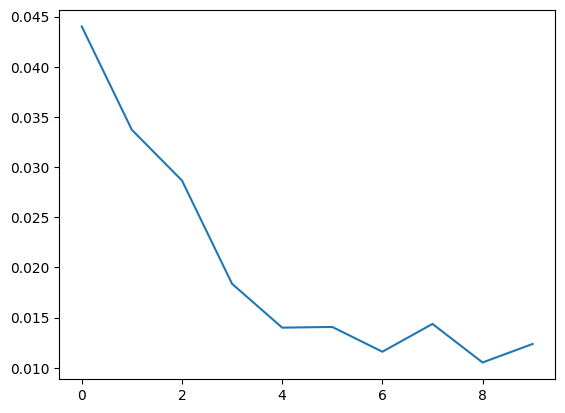

In [33]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.arange(0,epochs),history.history["loss"])
plt.show()

DatetimeIndex(['2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', freq='ME')
            produccion
DATE                  
2000-01-01     93.6497
2000-02-01    111.6591
2000-03-01    125.4885
2000-04-01    136.9998
2000-05-01    136.0725
...                ...
2023-02-01    119.2751
2023-03-01    122.0175
2023-04-01    126.6790
2023-05-01    121.1606
2023-06-01    130.4626

[282 rows x 1 columns]


C:\Users\JM\AppData\Local\Temp\ipykernel_12216\2551877584.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_pred_dates = pd.date_range(start=start_date, periods=len(y_pred), freq="M")


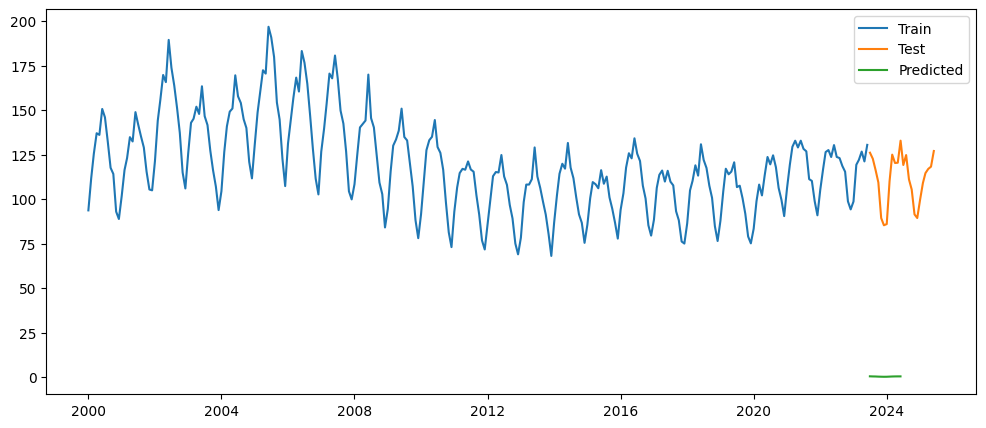

In [ ]:

y_pred = lstm_model.predict(val_gen, verbose=0)
start_date = train.iloc[-1].name
y_pred_dates = pd.date_range(start=start_date, periods=len(y_pred), freq="M")
plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(y_pred_dates, y_pred,label="Predicted")
plt.legend()
plt.show()